In [1]:
%matplotlib inline
%load_ext rpy2.ipython
import os
import scipy

GIMME_DIR = "/home/isaac/gimmeSAD"
SIMOUT_DIR = os.path.join(GIMME_DIR, "origin_sims/")

os.chdir(GIMME_DIR)
import gimmeSAD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random
import glob
import subprocess

## Gather all the simulations into one huge simout file

In [240]:
for origin in ["volcanic", "landbridge"]:
    REF_TABLE = os.path.join(SIMOUT_DIR, "{}-pi_x_dxys.log".format(origin))
    outfile = open(REF_TABLE, "w")

    files = glob.glob(SIMOUT_DIR + "*10000-*{}*/pi_x_dxy.log".format(origin))
    for f in files:
        lines = open(f).readlines()[1:]
        new_lines = []
        for line in lines:
            try:
                ## drop everything we don't care about including
                ## anything that's not data and all post-equilibrium lines
                if not "step" in line:
                    pass                    
                else:
                    new_lines.append(line)
            except:
                pass
        lines = new_lines
        ## Don't write blanks
        if lines:
            outfile.write("".join(lines))
    outfile.close()

In [241]:
voldat = open(os.path.join(SIMOUT_DIR, "volcanic-pi_x_dxys.log")).readlines()
landdat = open(os.path.join(SIMOUT_DIR, "landbridge-pi_x_dxys.log")).readlines()
voldat = [x.strip().split() for x in voldat]
landdat = [x.strip().split() for x in landdat]

In [242]:
print(len(voldat))
print(len(landdat))
print(voldat[-1])
print(landdat[-1])

101313
101555
['atEQ', 'True', 'step', '16300000', 'percent_equil', '0.9985', 'shannon', '4.1036651275', 'mean/stdv/median/iqr', 'pi', '0.00807648026316/0.00848093251977/0.00552631578947/0.00764035087719', 'mean/stdv/median/iqr', 'dxy', '0.00163285818713/0.00245244208703/0.000818713450292/0.00152046783626']
['atEQ', 'True', 'step', '14400000', 'percent_equil', '0.9998', 'shannon', '3.94061534622', 'mean/stdv/median/iqr', 'pi', '0.0125029239766/0.0556966109916/0.00482456140351/0.00736842105263', 'mean/stdv/median/iqr', 'dxy', '0.00153464469254/0.00251805539057/0.000701754385965/0.00190058479532']


## Calculate mean/median/iqr for pi and dxy for volcanic vs landbridge for various values of lambda

In [243]:
##
allstats = {}
allstats["volcanic"] = {}
allstats["landbridge"] = {}
for percent in [0.05, 0.08, 0.25, 0.5, 0.98, 1]:
    for k,v in {"volcanic":voldat, "landbridge":landdat}.items():
        meanpis = []
        stdvpis = []
        medianpis = []
        iqrpis = []
        meandxys = []
        stdvdxys = []
        shans = []
        mediandxys = []
        iqrdxys = []
        shanidx = 7
        pidx = 10
        dxyidx = 13
        for i, line in enumerate(v):
            try:
                if line[2] == 'True':
                    line[5] = 1
                if abs(float(line[5]) - percent) < 0.001:
                    meanpi, stdvpi, medianpi, iqrpi = line[pidx].split("/")
                    meanpis.append(float(meanpi))
                    stdvpis.append(float(stdvpi))
                    medianpis.append(float(medianpi))
                    iqrpis.append(float(iqrpi))

                    meandxy, stdvdxy, mediandxy, iqrdxy = line[dxyidx].split("/")
                    meandxys.append(float(meandxy))
                    stdvdxys.append(float(stdvdxy))
                    mediandxys.append(float(mediandxy))
                    iqrdxys.append(float(iqrdxy))

                    shannon = float(line[shanidx])
                    shans.append(float(shannon))
            except:
                pass
        print(k + " " + str(percent) + " numbins {}".format(len(meanpis)))
        print("mean/stdv/median/iqr pi - {a:.4f}/{b:.4f}/{c:.5f}/{d:.5f}".format(a=np.mean(meanpis), b=np.mean(stdvpis),\
                                                                                c=np.mean(medianpis), d=np.mean(iqrpis)))
        print("mean/stdv/median/iqr dxy - {a:.4f}/{b:.4f}/{c:.5f}/{d:.5f}".format(a=np.mean(meandxys), b=np.mean(stdvdxys),\
                                                                                c=np.mean(mediandxys), d=np.mean(iqrdxys)))
        print("mean/stdv shannon - {a:.4f}/{b:.4f}".format(a=np.mean(shans), b=np.std(shans)))
        allstats[k][percent] = (meanpis, stdvpis, meandxys, stdvdxys, shans)
    print("\n")

landbridge 0.05 numbins 325
mean/stdv/median/iqr pi - 0.1189/0.1099/0.16584/0.21749
mean/stdv/median/iqr dxy - 0.0097/0.0132/0.00250/0.01555
mean/stdv shannon - 4.0917/0.1330
volcanic 0.05 numbins 318
mean/stdv/median/iqr pi - 0.0089/0.0263/0.00437/0.00647
mean/stdv/median/iqr dxy - 0.0011/0.0042/0.00023/0.00079
mean/stdv shannon - 3.2033/0.7817


landbridge 0.08 numbins 302
mean/stdv/median/iqr pi - 0.0977/0.0987/0.03726/0.19270
mean/stdv/median/iqr dxy - 0.0087/0.0120/0.00198/0.01377
mean/stdv shannon - 4.1579/0.1571
volcanic 0.08 numbins 294
mean/stdv/median/iqr pi - 0.0088/0.0257/0.00452/0.00641
mean/stdv/median/iqr dxy - 0.0012/0.0039/0.00032/0.00092
mean/stdv shannon - 3.3986/0.6348


landbridge 0.25 numbins 191
mean/stdv/median/iqr pi - 0.0779/0.1037/0.01159/0.20610
mean/stdv/median/iqr dxy - 0.0083/0.0130/0.00154/0.01103
mean/stdv shannon - 4.1126/0.1317
volcanic 0.25 numbins 184
mean/stdv/median/iqr pi - 0.0084/0.0205/0.00495/0.00689
mean/stdv/median/iqr dxy - 0.0013/0.0035/0.

## Calculate mean/median/iqr for pi and dxy for 3 different colonization rates at various timepoints

### First just read in all the data from all the data for each colrate +/- some tolerance, only for 
### a specific range of K

In [2]:
SIMOUT_DIR = os.path.join(GIMME_DIR, "2d_sims/")
colrates = [0.003, 0.01, 0.05]
tolerance = 0.005
Kmin = 8000

for col in colrates:
    REF_TABLE = os.path.join(SIMOUT_DIR, "{}-pi_x_dxys.log".format(col))
    outfile = open(REF_TABLE, "w")

    files = glob.glob(SIMOUT_DIR + "*/pi_x_dxy.log")
    for f in files:
        thiscol = f.split("_")[3]
        if abs(float(thiscol) - col) > tolerance:
            continue
        thisK = f.split("/")[-2].split("_")[1].split("-")[0]
        if thisK == "x":
            continue
        if int(thisK) < Kmin:
            continue
        lines = open(f).readlines()[1:]
        new_lines = []
        for line in lines:
            try:
                ## drop everything we don't care about including
                ## anything that's not data and all post-equilibrium lines
                if not "step" in line:
                    pass                    
                else:
                    new_lines.append(line)
            except:
                pass
        lines = new_lines
        ## Don't write blanks
        if lines:
            outfile.write("".join(lines))
    outfile.close()

In [3]:
## Make a dictionary to hold the data for each colonization rate
coldat = {}
for col in colrates:
    tmpdat = open(os.path.join(SIMOUT_DIR, "{}-pi_x_dxys.log".format(col)))
    tmpdat = [x.strip().split() for x in tmpdat]
    coldat[col] = tmpdat
    print("{} len - {}".format(col, len(tmpdat)))

0.003 len - 338112
0.01 len - 213653
0.05 len - 21911


In [5]:
## Go through and get the mean/std/iqr for each colrate for each %equilibrium
row_list = []
colrates = [0.003, 0.01, 0.05]
meanstats = {}
medianstats = {}
fulldat = {}
for rt in colrates:
    meanstats[rt] = {}
    medianstats[rt] = {}
    fulldat[rt] = {}
for percent in [0.05, 0.08, 0.25, 0.5, 0.98, 1]:
    for k,v in coldat.items():
        meanpis = []
        stdvpis = []
        medianpis = []
        iqrpis = []
        meandxys = []
        stdvdxys = []
        shans = []
        mediandxys = []
        iqrdxys = []
        shanidx = 7
        pidx = 10
        dxyidx = 13
        for i, line in enumerate(v):
            try:
                ## Set all equilibrium sim runs to have %eq = 1
                if line[2] == 'True':
                    line[5] = 1
                if abs(float(line[5]) - percent) < 0.001:
                    meanpi, stdvpi, medianpi, iqrpi = line[pidx].split("/")
                    meanpis.append(float(meanpi))
                    stdvpis.append(float(stdvpi))
                    medianpis.append(float(medianpi))
                    iqrpis.append(float(iqrpi))

                    meandxy, stdvdxy, mediandxy, iqrdxy = line[dxyidx].split("/")
                    meandxys.append(float(meandxy))
                    stdvdxys.append(float(stdvdxy))
                    mediandxys.append(float(mediandxy))
                    iqrdxys.append(float(iqrdxy))

                    shannon = float(line[shanidx])
                    shans.append(float(shannon))
            except:
                pass
        print(str(k) + " " + str(percent) + " numbins {}".format(len(meanpis)))
        print("mean/stdv/median/iqr pi - {a:.4f}/{b:.4f}/{c:.5f}/{d:.5f}".format(a=np.mean(meanpis), b=np.mean(stdvpis),\
                                                                                c=np.mean(medianpis), d=np.mean(iqrpis)))
        print("mean/stdv/median/iqr dxy - {a:.4f}/{b:.4f}/{c:.5f}/{d:.5f}".format(a=np.mean(meandxys), b=np.mean(stdvdxys),\
                                                                                c=np.mean(mediandxys), d=np.mean(iqrdxys)))
        print("mean/stdv shannon - {a:.4f}/{b:.4f}".format(a=np.mean(shans), b=np.std(shans)))

        print("Medians")
        print("mean/stdv/median/iqr pi - {a:.4f}/{b:.4f}/{c:.5f}/{d:.5f}".format(a=np.median(meanpis), b=np.median(stdvpis),\
                                                                                c=np.median(medianpis), d=np.median(iqrpis)))
        print("mean/stdv/median/iqr dxy - {a:.4f}/{b:.4f}/{c:.5f}/{d:.5f}".format(a=np.median(meandxys), b=np.median(stdvdxys),\
                                                                                c=np.median(mediandxys), d=np.median(iqrdxys)))
        print("mean/stdv shannon - {a:.4f}/{b:.4f}".format(a=np.median(shans), b=scipy.stats.iqr(shans)))

        #allstats[k][percent] = (meanpis, stdvpis, meandxys, stdvdxys, shans)
        ## TMI just track the means
        meanstats[k][percent] = (np.mean(meanpis), np.mean(stdvpis), np.mean(medianpis), np.mean(iqrpis),\
                                np.mean(meandxys), np.mean(stdvdxys), np.mean(mediandxys), np.mean(iqrdxys), np.mean(shans), np.std(shans))
        medianstats[k][percent] = (np.median(meanpis), np.median(stdvpis), np.median(medianpis), np.median(iqrpis),\
                                np.median(meandxys), np.median(stdvdxys), np.median(mediandxys), np.median(iqrdxys), np.mean(shans), scipy.stats.iqr(shans))

        fulldat[k][percent] = np.array([meanpis, stdvpis, medianpis, iqrpis, \
                                meandxys, stdvdxys, mediandxys, iqrdxys, shans, shans])

    print("\n")

0.003 0.05 numbins 1126
mean/stdv/median/iqr pi - 0.0118/0.0365/0.00523/0.00723
mean/stdv/median/iqr dxy - 0.0013/0.0042/0.00034/0.00100
mean/stdv shannon - 3.1021/0.6818
Medians
mean/stdv/median/iqr pi - 0.0087/0.0092/0.00500/0.00702
mean/stdv/median/iqr dxy - 0.0011/0.0025/0.00035/0.00096
mean/stdv shannon - 2.7930/1.3405
0.05 0.05 numbins 111
mean/stdv/median/iqr pi - 0.0049/0.0082/0.00257/0.00513
mean/stdv/median/iqr dxy - 0.0017/0.0042/0.00003/0.00119
mean/stdv shannon - 3.9620/0.0574
Medians
mean/stdv/median/iqr pi - 0.0049/0.0080/0.00263/0.00506
mean/stdv/median/iqr dxy - 0.0017/0.0040/0.00000/0.00105
mean/stdv shannon - 3.9649/0.0823
0.01 0.05 numbins 595
mean/stdv/median/iqr pi - 0.0072/0.0171/0.00376/0.00610
mean/stdv/median/iqr dxy - 0.0011/0.0037/0.00012/0.00070
mean/stdv shannon - 3.0928/0.8796
Medians
mean/stdv/median/iqr pi - 0.0066/0.0094/0.00368/0.00601
mean/stdv/median/iqr dxy - 0.0011/0.0034/0.00000/0.00070
mean/stdv shannon - 2.4619/1.7571


0.003 0.08 numbins 1105


In [95]:
mean_df = pd.DataFrame(meanstats)#, columns = ["mean", "stdv", "median", "iqr", "shannon"])
median_df = pd.DataFrame(medianstats)
print("mean")
print(mean_df)
print("\nmedian")
print(median_df)

mean
                                                                                                                                                                                0.003  \
0.05  (0.0115949521383, 0.0364749961584, 0.00512753270459, 0.00711842612311, 0.00129848750391, 0.00439517887663, 0.000320837417886, 0.000959086862951, 3.11290787002, 0.694468422061)   
0.08  (0.0111389076688, 0.0334485371854, 0.00538306776115, 0.00728090294544, 0.00130589466973, 0.00408366671485, 0.000392210776687, 0.00107776928304, 3.27419962621, 0.569382477485)    
0.25  (0.0103581565262, 0.0247394291591, 0.00600801496126, 0.00800362157509, 0.00151458885394, 0.00373504627021, 0.000564477559757, 0.00144978445361, 3.55517662766, 0.304701176877)    
0.50  (0.0101723329516, 0.0203432397196, 0.0062052907137, 0.00805332047396, 0.0016621726972, 0.00358020825365, 0.000683894144903, 0.00169376320382, 3.67516262129, 0.210699839028)      
0.98  (0.00881102678476, 0.0117295657538, 0.00588744552464, 0.00785755

In [12]:
paramsdict = {0:"meanpis", 1:"stdvpis", 2:"medianpis", 3:"iqrpis", \
            4:"meandxys", 5:"stdvdxys", 6:"mediandxys", 7:"iqrdxys", 8:"shans"}
def plot_colrates_through_time(param, name):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6), sharey=True)
    fig.suptitle(name)
    for i, col in enumerate(colrates):
        dat = []
        for percent in [0.08, 0.25, 0.5, 0.98]:
            dat.append(fulldat[col][percent][param])
        axes[i].boxplot(dat, meanline=True, showmeans=True)
        axes[i].set_title(col)

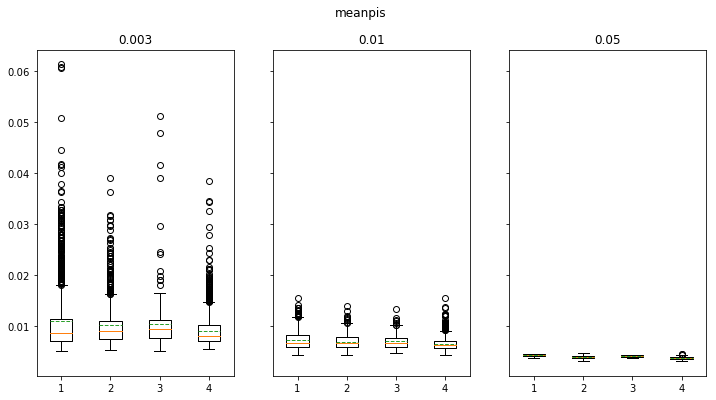

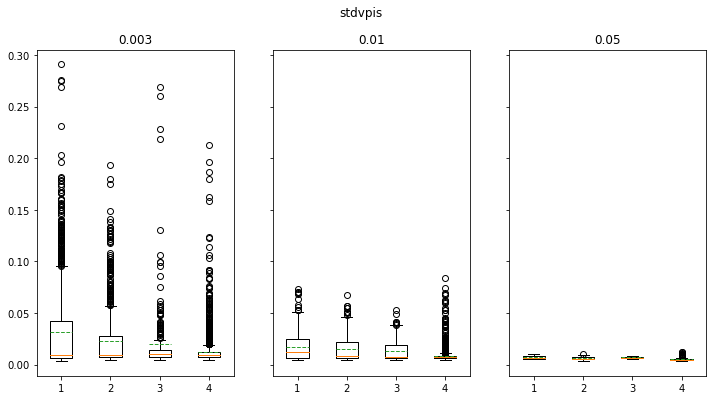

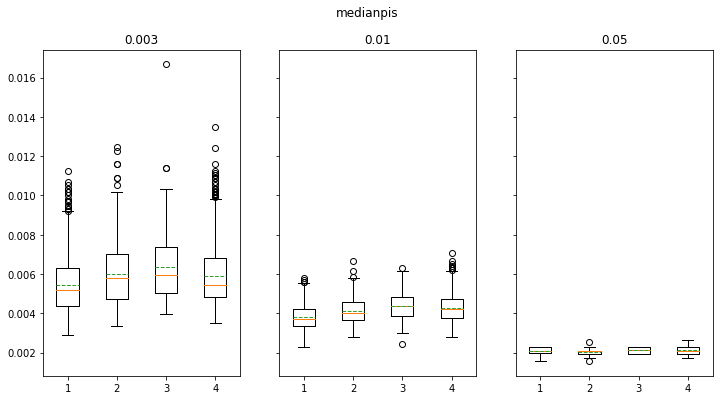

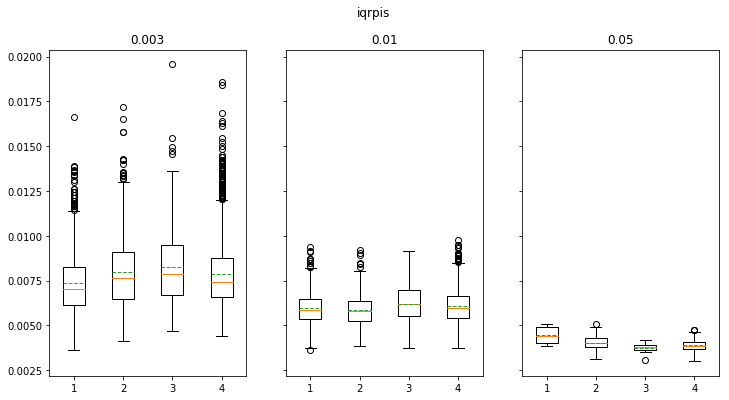

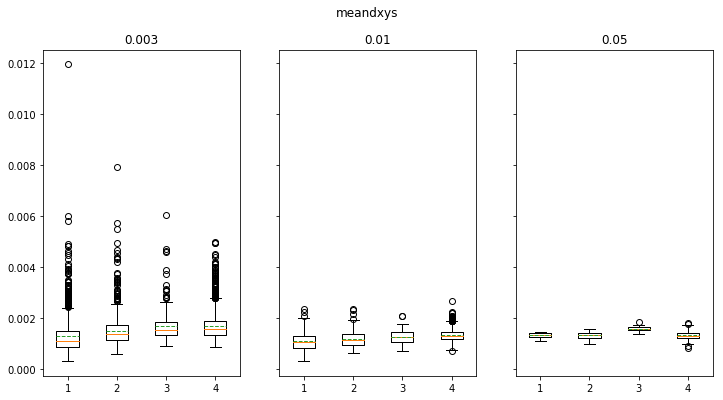

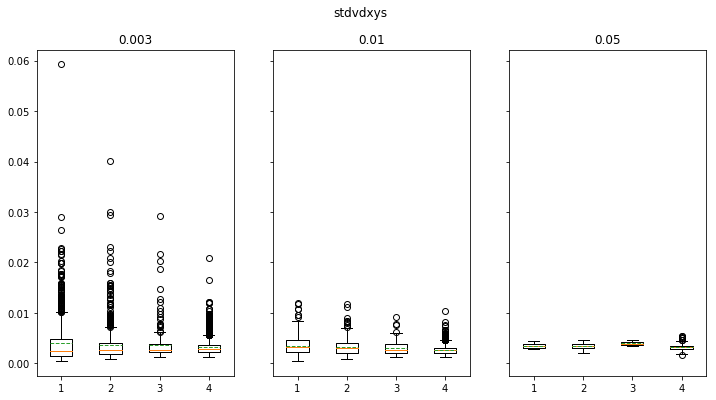

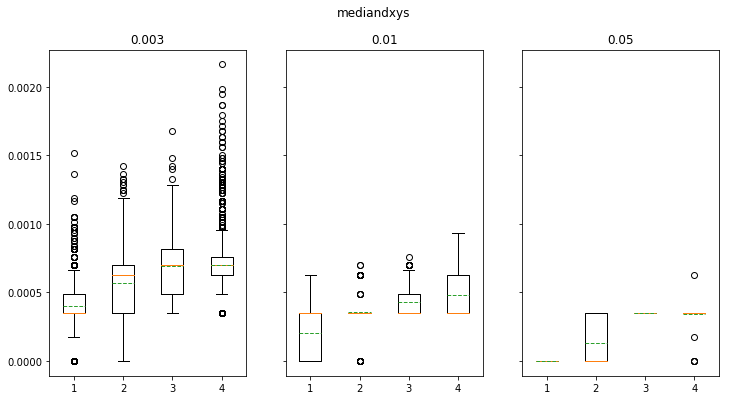

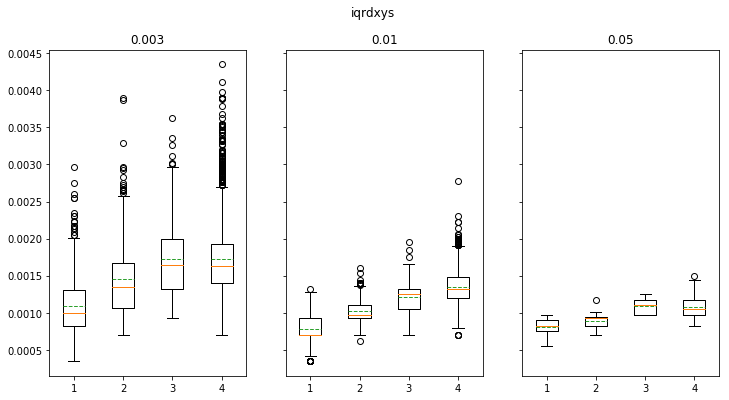

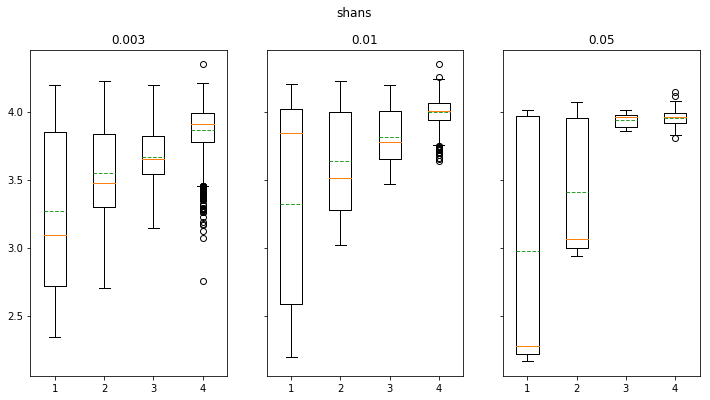

In [13]:
for k,v in paramsdict.items():
    plot_colrates_through_time(k, v)

{'boxes': [<matplotlib.lines.Line2D at 0x7fbdd16cd310>,
 'caps': [<matplotlib.lines.Line2D at 0x7fbdd16dc290>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fbdd16ec590>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fbdd16dcf10>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7fbdd16cd510>,
  <matplotlib.lines.Line2D at 0x7fbdd18287d0>]}

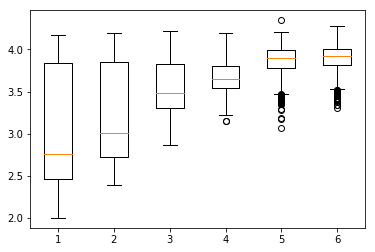

In [143]:
plt.boxplot(dat)

{'boxes': [<matplotlib.lines.Line2D at 0x7fbdd1b74bd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fbdd1b84b50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fbdd1b11e50>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fbdd1b11810>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7fbdd1b74dd0>,
  <matplotlib.lines.Line2D at 0x7fbdd1c089d0>]}

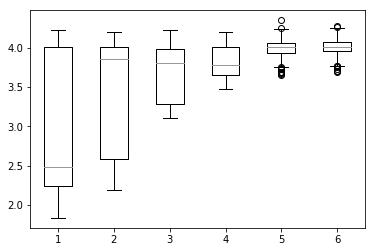

In [141]:
dat = []
for percent in [0.05, 0.08, 0.25, 0.5, 0.98, 1]:
    
    dat.append(fulldat[0.01][percent][8])
plt.boxplot(dat)